# Exploratory Analysis

In [1]:
import pandas as pd

In [2]:
data_load = pd.read_csv("/home/romaric/code/nghia95/fake-data-detector/data/1k_sampled_dataset.csv")
data = data_load.copy()
data.head()

,text,source,prompt_id,text_length,word_count
0,The Philosophy and Ethics of Transhumanism\n\n...,GPT-3.5,1920,2558,394
1,Crime-tracking app Citizen is launching its ow...,Flan-T5-XXL,0,378,62
2,The court in Novorossiysk gave two of the danc...,GLM-130B,0,621,109
3,"then drops the drumsticks, poses, then walks o...",GPT-J,0,513,90
4,On tally went to the beach. She found a sand d...,GPT-J,0,4984,846


In [3]:
data.shape

(1000, 5)

In [4]:
import matplotlib.pyplot as plt

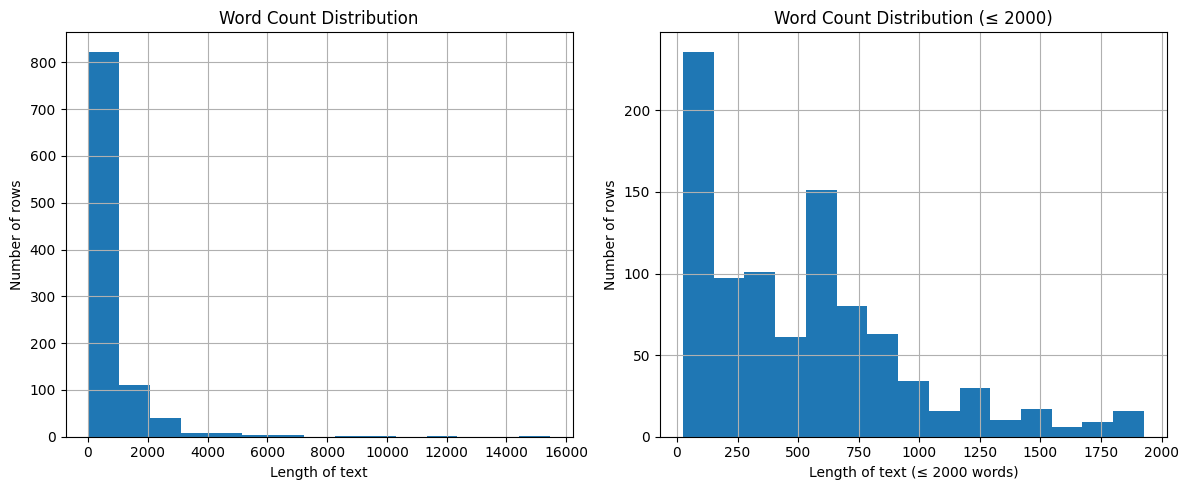

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


data['word_count'].hist(ax=ax[0], bins=15)
ax[0].set_xlabel("Length of text")
ax[0].set_ylabel("Number of rows")
ax[0].set_title("Word Count Distribution")


data[data['word_count'] <= 2000]['word_count'].hist(ax=ax[1], bins=15)
ax[1].set_xlabel("Length of text (≤ 2000 words)")
ax[1].set_ylabel("Number of rows")
ax[1].set_title("Word Count Distribution (≤ 2000)")


plt.tight_layout()
plt.show()

In [6]:
data["source"].value_counts()

source
Human                   559
GPT-3.5                 138
Flan-T5-XXL              31
GPT-J                    29
Flan-T5-Large            28
Flan-T5-Small            26
Flan-T5-Base             26
GLM-130B                 26
GPT-4                    24
Claude-Instant-v1        24
Bloom-7B                 23
Flan-T5-XL               18
GPT-NeoX                 16
Falcon-180B              15
Claude-v1                10
Goliath-120B              3
Dolphin-Mixtral-8x7B      2
Gemini-Pro                1
Cohere-Command            1
Name: count, dtype: int64

In [7]:
data["AI_gen"] = data["source"].apply(lambda x: 0 if x == "Human" else 1)
data.head()

,text,source,prompt_id,text_length,word_count,AI_gen
0,The Philosophy and Ethics of Transhumanism\n\n...,GPT-3.5,1920,2558,394,1
1,Crime-tracking app Citizen is launching its ow...,Flan-T5-XXL,0,378,62,1
2,The court in Novorossiysk gave two of the danc...,GLM-130B,0,621,109,1
3,"then drops the drumsticks, poses, then walks o...",GPT-J,0,513,90,1
4,On tally went to the beach. She found a sand d...,GPT-J,0,4984,846,1


In [8]:
data["AI_gen"].value_counts()

AI_gen
0    559
1    441
Name: count, dtype: int64

# What is our objective?

Objectif: Being able to sort texts between Human written or Ai generated.
Intuition: Especially if we use LLM, we should have a clear idea of what differentiate Human writting from AI generated text.
Research: 
-**Differentiating between human-written and AI-generated texts using linguistic features automatically extracted from an online computational tool** ++ Georgios P. Georgiou
      result: *AI models might influence their stylistic choices, potentially favoring sentences with a higher consonant density or stronger stress patterns. The internal algorithms governing AI text generation might prioritize specific phonological features during the construction of sentences. These results suggest that AI models may have inherent biases in consonant production, possibly due to the training data or the specific algorithms used.* https://arxiv.org/abs/2407.03646

- **How To Identify AI-Generated Text?**++Jonathan Gillham
    result: *It’s very rare for an AI content generator to make grammatical mistakes. Repetition or redundancy of words or phrases.  Absence of emotion or personality. Unusual choice of words.  Lack of context; irrelevance. Lack of tone and style.*
https://originality.ai/blog/identify-ai-generated-text

On the fly, I also found out that a tool such as "textstat","phonemizer" and "ntlk" could be useful if we follow those rules to determinate the origin of a text.

Consonant Density (Higher)	<br>
Sentence Stress Patterns (Higher)	==> CMUdict gives syllables of words in the english language<br>
Repetition & Redundancy (Higher)	==> nltk.tokenize<br>
Emotion & Personality (None)	==> TextBlob	<br>
Unusual Word Choices		<br>
Context & Coherence	==> gensim (https://radimrehurek.com/gensim/models/lsimodel.html)  <br>
Tone & Readability ==> textstat.flesh_reading_ease https://pypi.org/project/textstat/<br>

#### **/_\ Install in the environment**

In [9]:
pip install textstat textblob nltk syllapy gensim

Note: you may need to restart the kernel to use updated packages.


# Extracting features

## Create feature and target to work with. <br>
X will be data["preprocessed"] and y will be data["AI_gen"]

In [ ]:
X=pd.DataFrame(data["text"])
y=data["AI_gen"]

In [41]:
print(X.shape)
print(y.shape)

(3, 1)
(1000,)


## Text Preprocessing

Def basic_cleaning to clean up the column text.

In [42]:
import string
import re
def basic_cleaning(x):
    # remove whitespace
    x = x.strip()
    # lowercasing
    x = x.lower()
    # remove digits
    x = "".join(char for char in x if not char.isdigit())
    # remove punctuation
    for punctuation in string.punctuation:
        x = x.replace(punctuation," ")
    # remove regex
    x = re.sub('<[^<]+?',"",x)

    return x

In [43]:
X["preprocessed"] = X["text"].apply(lambda x: basic_cleaning(x))
X.head()

,text,preprocessed
0,The Philosophy and Ethics of Transhumanism\n\n...,the philosophy and ethics of transhumanism\n\n...
1,Crime-tracking app Citizen is launching its ow...,crime tracking app citizen is launching its ow...
2,The court in Novorossiysk gave two of the danc...,the court in novorossiysk gave two of the danc...


## Create more features based on our research to help identifying AI generated text

In [44]:
X.head()

,text,preprocessed
0,The Philosophy and Ethics of Transhumanism\n\n...,the philosophy and ethics of transhumanism\n\n...
1,Crime-tracking app Citizen is launching its ow...,crime tracking app citizen is launching its ow...
2,The court in Novorossiysk gave two of the danc...,the court in novorossiysk gave two of the danc...


Consonant Density <br>
Sentence Stress Patterns	==> CMUdict gives syllables of words in the english language <br>
Repetition & Redundancy	==> nltk.tokenize<br>
Emotion & Personality	==> TextBlob	https://textblob.readthedocs.io/en/dev/api_reference.html#textblob.blob.TextBlob.sentiment<br>
Unusual Word Choices		<br>
Context & Coherence	==> gensim (https://radimrehurek.com/gensim/models/lsimodel.html) <br>
Tone & Readability ==> textstat.flecsh_reading_ease https://pypi.org/project/textstat/<br>

### Consonnant Density

In [45]:
def cons_density(text):

    consonnant = sum(1 for char in text if char.isalpha() and char not in "aeiou")
    vowel = sum(1 for char in text if char.isalpha() and char in "aeiou")
    return round((consonnant/(vowel + consonnant)),3)

In [46]:
X["cons_density"] = X["preprocessed"].apply(lambda x: cons_density(x))
X.head()

,text,preprocessed,cons_density
0,The Philosophy and Ethics of Transhumanism\n\n...,the philosophy and ethics of transhumanism\n\n...,0.599
1,Crime-tracking app Citizen is launching its ow...,crime tracking app citizen is launching its ow...,0.613
2,The court in Novorossiysk gave two of the danc...,the court in novorossiysk gave two of the danc...,0.622


### Stress Pattern

In [47]:
import nltk
from nltk.corpus import cmudict

nltk.download('cmudict')
cmu_dict = cmudict.dict()

[nltk_data] Downloading package cmudict to /home/romaric/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fb94167b670>>
Traceback (most recent call last):
  File "/home/romaric/.pyenv/versions/fake-data-detector/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [48]:
def get_word_stress(word):
    if word in cmu_dict:
        return sum(int(char) for syllable in cmu_dict[word][0] for char in syllable if char.isdigit())
    return 0

def get_sentence_stress(sentence):
    words = sentence.split()
    stress_values = [get_word_stress(word) for word in words]
    return sum(stress_values)

In [49]:
X["stress_value"] = (X["preprocessed"].apply(lambda x: get_sentence_stress(x)))/len(X["preprocessed"])
X.head()

,text,preprocessed,cons_density,stress_value
0,The Philosophy and Ethics of Transhumanism\n\n...,the philosophy and ethics of transhumanism\n\n...,0.599,126.666667
1,Crime-tracking app Citizen is launching its ow...,crime tracking app citizen is launching its ow...,0.613,21.333333
2,The court in Novorossiysk gave two of the danc...,the court in novorossiysk gave two of the danc...,0.622,31.333333


### Repetition and Redundancy

In [50]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/romaric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/romaric/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/romaric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/romaric/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [51]:
def redundance(text):
    # give a redundance score, considering the lenght of each text, if a lemmatized words appears more than three times the mean, it is considered redundant.

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    clean_tokens = [w for w in tokens if w not in stop_words]

    lemmatizer = WordNetLemmatizer()
    verb_lemmas = {word: lemmatizer.lemmatize(word, pos='v') for word in clean_tokens}

    final_lemmas = [lemmatizer.lemmatize(lemma, pos='n') if lemma == word else lemma
                    for word, lemma in verb_lemmas.items()]

    word_counts = Counter(final_lemmas)
    mean_freq = sum(word_counts.values()) / len(word_counts)

    score = sum(1 for word, count in word_counts.items() if count > 3 * mean_freq)

    return score

In [52]:
X["token_redundance"] = X["preprocessed"].apply(lambda x : redundance(x))
X.head()

,text,preprocessed,cons_density,stress_value,token_redundance
0,The Philosophy and Ethics of Transhumanism\n\n...,the philosophy and ethics of transhumanism\n\n...,0.599,126.666667,0
1,Crime-tracking app Citizen is launching its ow...,crime tracking app citizen is launching its ow...,0.613,21.333333,0
2,The court in Novorossiysk gave two of the danc...,the court in novorossiysk gave two of the danc...,0.622,31.333333,0


### Emotion and personality
Hate or love, AI lacks of it, so i'm using sentiment polarity of textblob as an absolute value

In [53]:
from textblob import TextBlob # https://textblob.readthedocs.io/en/dev/api_reference.html#textblob.blob.TextBlob.sentiment

In [54]:
def sentiment_polarity(text):
    sent_pol = TextBlob(text).sentiment.polarity
    return abs(round(sent_pol,3))

In [55]:
X['sentiment_score'] = X['preprocessed'].apply(lambda x: sentiment_polarity(x))

In [56]:
X.head()

,text,preprocessed,cons_density,stress_value,token_redundance,sentiment_score
0,The Philosophy and Ethics of Transhumanism\n\n...,the philosophy and ethics of transhumanism\n\n...,0.599,126.666667,0,0.066
1,Crime-tracking app Citizen is launching its ow...,crime tracking app citizen is launching its ow...,0.613,21.333333,0,0.167
2,The court in Novorossiysk gave two of the danc...,the court in novorossiysk gave two of the danc...,0.622,31.333333,0,0.087


### Unusual word choice
=> https://aiphrasefinder.com/common-ai-words/

In [57]:
def word_choice(text):
    common_ai_words =["commendable",'transhumanist', 'meticulous', 'elevate','hello', 'tapestry' 'leverage',
                  'journey', 'headache','resonate','testament','explore', 'binary','delve',
                  'enrich', 'seamless','multifaceted', 'sorry','foster', 'convey', 'beacon',
                  'interplay', 'oh', 'navigate','form','adhere','cannot', 'landscape','remember',
                  'paramount', 'comprehensive', 'placeholder','grammar','real','summary','symphony',
                  'furthermore','relationship','ultimately','profound','art','supercharge','evolve',
                  'beyoud','reimagine','vibrant', 'robust','pivotal','certainly','quinoa','orchestrate','align',
                  'diverse','recommend','annals','note','employ','bustling','indeed','digital','enigma', 'outfit',
                  'indelible','refrain','culture','treat','emerge','meticulous','esteemed','weight','whimsical','bespoke',
                  'highlight','antagonist','unlock','key','breakdown','tailor','misinformation','treasure','paradigm','captivate',
                  'song','underscore','calculate','especially','climate','hedging','inclusive','exercise','ai','embrace',
                  'level','nuance','career','dynamic','accent','ethos','cheap','firstly','online','goodbye'
                  ]
    word_count = 0
    for word in text.split():
        if word in common_ai_words:
            word_count += 1
        else: pass

    return word_count


In [58]:
X["Unusual_words_count"] = X["preprocessed"].apply(lambda x: word_choice(x))
X.head()

,text,preprocessed,cons_density,stress_value,token_redundance,sentiment_score,Unusual_words_count
0,The Philosophy and Ethics of Transhumanism\n\n...,the philosophy and ethics of transhumanism\n\n...,0.599,126.666667,0,0.066,1
1,Crime-tracking app Citizen is launching its ow...,crime tracking app citizen is launching its ow...,0.613,21.333333,0,0.167,0
2,The court in Novorossiysk gave two of the danc...,the court in novorossiysk gave two of the danc...,0.622,31.333333,0,0.087,0


### Context and coherence
*Latent Semantic Analysis (LSA) is used as a technique for measuring the coherence of texts. By comparing the vectors for 2 adjoining segments of text in a high‐dimensional semantic space, <br>the method provides a characterization of the degree of semantic relatedness between the segments.*<br> ==> GENSIM https://radimrehurek.com/gensim/models/lsimodel.html

In [59]:
from gensim.models import LsiModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

In [60]:
def coherence(text):
    # uses gensim to measure coherence, use the lsi model(latent semantic indexing, coherence c_v because we provide the text)
    tokens = word_tokenize(text)
    dictionary = corpora.Dictionary([tokens])
    corpus_gensim = [dictionary.doc2bow(tokens)]
    lsa_model = LsiModel(corpus_gensim, id2word=dictionary)

    coherence_model = CoherenceModel(
        model=lsa_model,
        texts=[tokens],
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [61]:
X["coherence_score"] = X["preprocessed"].apply(lambda x: coherence(x))

In [62]:
X.head()

,text,preprocessed,cons_density,stress_value,token_redundance,sentiment_score,Unusual_words_count,coherence_score
0,The Philosophy and Ethics of Transhumanism\n\n...,the philosophy and ethics of transhumanism\n\n...,0.599,126.666667,0,0.066,1,0.198914
1,Crime-tracking app Citizen is launching its ow...,crime tracking app citizen is launching its ow...,0.613,21.333333,0,0.167,0,1.000000
2,The court in Novorossiysk gave two of the danc...,the court in novorossiysk gave two of the danc...,0.622,31.333333,0,0.087,0,1.000000


### Readability
textstat seems perfect for this job!
Because of the relativity of the feature, we'll build two columns of "imperfect" measures using text.stat.flecsh_ease_reading and text.stat.gunning_fog
they both measure the readbility of the text against the level of American standards for a grade level. <br>see -> https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease |The lower the harder to read! (negative score possible)| max score 121.22(easiest)<br>
and https://en.wikipedia.org/wiki/Gunning_fog_index | clasify between first grade (0) text and over College graduate text (20)

In [63]:
import textstat

def reading_ease(text):
    reading_ease= textstat.flesch_reading_ease(text)
    return reading_ease


def gunning_fog(text):
    gunning_fog = textstat.gunning_fog(text)
    return gunning_fog

In [64]:
X["reading_ease"] = X["text"].apply(lambda x: reading_ease(x))

In [65]:
X["gunning_fog"] = X["text"].apply(lambda x: gunning_fog(x))

In [66]:
X.head()

,text,preprocessed,cons_density,stress_value,token_redundance,sentiment_score,Unusual_words_count,coherence_score,reading_ease,gunning_fog
0,The Philosophy and Ethics of Transhumanism\n\n...,the philosophy and ethics of transhumanism\n\n...,0.599,126.666667,0,0.066,1,0.198914,25.08,14.57
1,Crime-tracking app Citizen is launching its ow...,crime tracking app citizen is launching its ow...,0.613,21.333333,0,0.167,0,1.000000,50.43,7.54
2,The court in Novorossiysk gave two of the danc...,the court in novorossiysk gave two of the danc...,0.622,31.333333,0,0.087,0,1.000000,66.27,12.76
